# Reduced Dataset from UCI 

## Loading data and calculating indices 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for the progress bar :) 

In [3]:
# for single csv file of 1,000 instants, use this directory & change file name as needed
#Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/12_Files_1000_instant_each/"
#File_name = "1.csv" # files 1 - 12, each with 1,000 instants

# To load all data from a single file: 
Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/Single_File/"
File_name = "All_Signals.csv" # All instants, 12,000, in a single csv file

# Now read data header-less then give the col names
Signals = pd.read_csv(Data_Dir + File_name, header=None) #.reset_index()
Signals.columns = ['PPG','ABP','ECG'] # adding columns' names

# Reading the instants' lengthes to be used for calculating indices
Data_Indices = pd.read_csv(Data_Dir+"Instants_Length.csv", header=None)
Data_Indices.columns = ['Num_Samples']

# Calculating Instant Indices, Start & End
End_indices = np.cumsum(Data_Indices["Num_Samples"])
Start_indices = np.append(0, End_indices) 

# Sampling frequency
Fs=125

## Converting signals into PTT, PTTm, PTTh, HR, SBP, DBP, MAP values

In [9]:
# Looping over the instants, processing them one by one, storing processed data (PTT, SBP, DBP) in another dataframe
All_Instants_Data = pd.DataFrame() 

# Which instants would you like to explore?
iStart, iEnd = 1, 12000 # 1:12,000 
Instants_ID = np.arange(iStart - 1, iEnd)
Subset_Size = 8*125 # how many seconds to take at a time

for ID in tqdm(Instants_ID):  
    Instant_DF = Process_Instant(Signals.iloc[Start_indices[ID]:End_indices[ID]+1], Subset_Size)  # Processing data for 1 instant
    All_Instants_Data = All_Instants_Data.append(Instant_DF, ignore_index=True) # Appending to the whole processed dataset

  2%|███                                                                                                                                                                                                | 189/12000 [00:19<21:30,  9.15it/s]C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [15:13<00:00, 13.14it/s]


In [24]:
All_Instants_Data.describe()

,PTTh,PTTm,PTT,HR,SBP,DBP,MAP
count,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000,224017.000000
mean,1.502436,1.125356,0.575596,92.394599,133.576023,71.387614,93.667467
std,0.471776,0.467996,0.328781,15.733808,20.316135,9.771469,11.612897
min,0.132734,0.030500,0.008000,54.415423,80.019000,60.000000,66.646760
25%,1.391544,0.924800,0.432667,80.456582,118.808333,64.047526,85.024067
50%,1.673225,1.120000,0.612571,91.519219,132.973333,68.917933,91.924155
75%,1.827060,1.282667,0.664615,102.120974,148.020000,76.167333,100.996230
max,2.608299,4.086000,2.256800,155.795596,180.000000,129.955385,148.771474


In [40]:
All_Instants_Data.loc[:,['HR','SBP', 'DBP','MAP']].describe().to_csv("data_description_after_removing_outliers.csv")#Saving Stats

In [14]:
All_Instants_Data.to_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv') # Saving Dataset

## Helper Functions

### PPG, ABP, ECG signals to PTT, PTTm, PTTh, SBP, DBP, MAP, HR values

In [8]:
def Process_Instant(Signals, Subset_Size = 125*3): # defulat Subset_Size to cover 3 seconds of data samples
    
    import numpy as np
    from scipy.signal import find_peaks
    import pandas as pd
    
    N_tot = len(Signals.index) # Total number of samples
    N_ps = Subset_Size # Num of points per subset
    N_ss = N_tot//N_ps # Number of subsets (each with N_ps points), discarding the last points < N_ps
    All_data=pd.DataFrame() # an empty DF to store the parameters we got from the processed data 
    fs=125 # used to convert PPTp from Number_of_samples to time (same as in main. If changed, pass it to this fn)
    
    for i in range(N_ss):  # USE find_peaks_cwt instead??
           
        # I found, imperically, that find_peaks works better for PPG compared with ECG & ABP
        # So, I am detecting PPG peaks fisrt, then using 0.8*its average distance to be the min spacing for ECG & ABP peaks!
        # Hopefully this may return more accurate PTT calculations
        
        
        # PPG peaks' locations
        PPG_peaks, _ = find_peaks(Signals['PPG'][i*N_ps:(i+1)*N_ps], distance=40)
        if len(PPG_peaks)<2: 
            print('PPG')
            continue
        
        New_dist = 0.8*np.mean(np.diff(PPG_peaks))
        
        # PPG min' locations
        PPG_min, _ = find_peaks(-1*Signals['PPG'][i*N_ps:(i+1)*N_ps], distance=New_dist)
        if len(PPG_min)<2: 
            print('PPG')
            continue
        
        # ECG peaks' locations & MAP 
        ECG_peaks, _ = find_peaks(Signals['ECG'][i*N_ps:(i+1)*N_ps], distance=New_dist) 
        MAP = np.mean(Signals['ABP'].iloc[i*N_ps + np.arange(ECG_peaks[0], ECG_peaks[-1]+1)].values) #### VALUES not indicies
        if len(ECG_peaks)<2: 
            print('ECG')
            continue
        
        
        if PPG_peaks[-1]<ECG_peaks[0]: 
            print('ECG lagging too much')
            continue
        
        # PPT Calculations:
        # The 1st PPG peak has to lag the 1st ECG peak, if not then drop it and consider the next one.
        Lp, Le, Lm = len(PPG_peaks), len(ECG_peaks), len(PPG_min)
        min_pe = min(Lp, Le, Lm)
        Lpe = min(Lp,Le)
        Lme = min(Lm,Le)
        Lmp = min(Lp,Lm)
        
        if (PPG_peaks[0]>ECG_peaks[0]) and (PPG_min[0]>PPG_peaks[0]): # may add more conditions here for ACCEPTABLE PTT values
            PTT_vec = PPG_peaks[:Lpe] - ECG_peaks[:Lpe]
            PTT_min_vec = PPG_min[:Lme] - ECG_peaks[:Lme]
            PTT_h_vec = Signals['PPG'].iloc[i*N_ps + PPG_peaks[:Lmp]].values - Signals['PPG'].iloc[i*N_ps + PPG_min[:Lmp]].values #### VALUES not indicies
            
        else: # start from the 2nd PPG peak all the way to one before the last ECG peak
            s = 1
            while (PPG_peaks[s]<ECG_peaks[0]) and (s<=Lp-1):
                s+=1
            ind_max_ECG = min(Lp-s,Le) # common last elem index between max & ECG vectors
            PTT_vec = PPG_peaks[s:s+ind_max_ECG] - ECG_peaks[:ind_max_ECG] # PATp
            
            # Now making sure that min's follows max's
            r = 0
            while (PPG_min[r]<PPG_peaks[s]) and (r<=Lm-1):
                r+=1
            ind_m_ECG = min(Lm-r,Le) # common last elem index between min & ECG vectors
            PTT_min_vec = PPG_min[r:r+ind_m_ECG] - ECG_peaks[:ind_m_ECG] # PATf
            ind_h_min = min(Lp-s, Lm-r) # common last elem index between min & max vectors
            PTT_h_vec = Signals['PPG'].iloc[i*N_ps + PPG_peaks[s:s+ind_h_min]].values - Signals['PPG'].iloc[i*N_ps + PPG_min[r:r+ind_h_min]].values # PPGmax - PPGmin (i.e. PPG height)
        
        PTT_vec_p = [x for x in PTT_vec if x>0] # forcing positive values
        PTT_min_vec_p = [x for x in PTT_min_vec if x>0]
        PTT_h_vec_p = [x for x in PTT_h_vec if x>0]
        
        PTT_avg = np.mean(PTT_vec_p)
        PTT_min_avg = np.mean(PTT_min_vec_p)
        PTT_h_avg = np.mean(PTT_h_vec_p)
        
        
        
        # BP Min & Max Peaks' (DBP & SBP) locations
        BPmax_peaks, _ = find_peaks(Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=New_dist) # indices of SBP
        BPmin_peaks, _ = find_peaks(-1*Signals['ABP'][i*N_ps:(i+1)*N_ps], distance=New_dist) # indices of DBP
        
        
            # Calculate HR by averaging distances from ECG, PPG, BPmax, BPmin
        HR_ECG = np.mean(np.diff(ECG_peaks))
        HR_PPG = np.mean(np.diff(PPG_peaks))
        HR_PPG_min = np.mean(np.diff(PPG_min))
        HR_SBP = np.mean(np.diff(BPmax_peaks))
        HR_DBP = np.mean(np.diff(BPmin_peaks))
        HR_avg = 125*60/((HR_ECG + HR_PPG + HR_SBP + HR_DBP + HR_PPG_min)/5) # HR per minute
        ############################ 125*60/(mean(diff))
        
        # Creating DF's of SBP, DBP, and HR along with the time axis to be merged with the Subset DF
        SBP_avg = np.mean(Signals.iloc[i*N_ps + BPmax_peaks].loc[:,['ABP']])
        DBP_avg = np.mean(Signals.iloc[i*N_ps + BPmin_peaks].loc[:,['ABP']]) 
        
        
        # Append log_PPT, log-scale is more convinient for estimating BP (inspired from an approx eqn)
        Subset_DF = pd.DataFrame({'PTT':np.log(PTT_avg/fs), 
                                  'PTTm':np.log(PTT_min_avg/fs), 
                                  'PTTh':PTT_h_avg,
                                  'SBP':SBP_avg,
                                  'DBP':DBP_avg,
                                  'MAP':MAP,
                                  'HR':HR_avg})
         
        
        # Finally, append the DF of the current subset to the whole DF for all patients (may add more numerics, ID, ... later)
        All_data=All_data.append(Subset_DF, ignore_index=True)
    return All_data
    

# Start Here When You Have Processed Data! 

## 3) Preparing Data for Regression [Predictive Models]

### 3.0 Load Data, Remove NaN & Outliers

In [88]:
import pandas as pd
import numpy as np

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

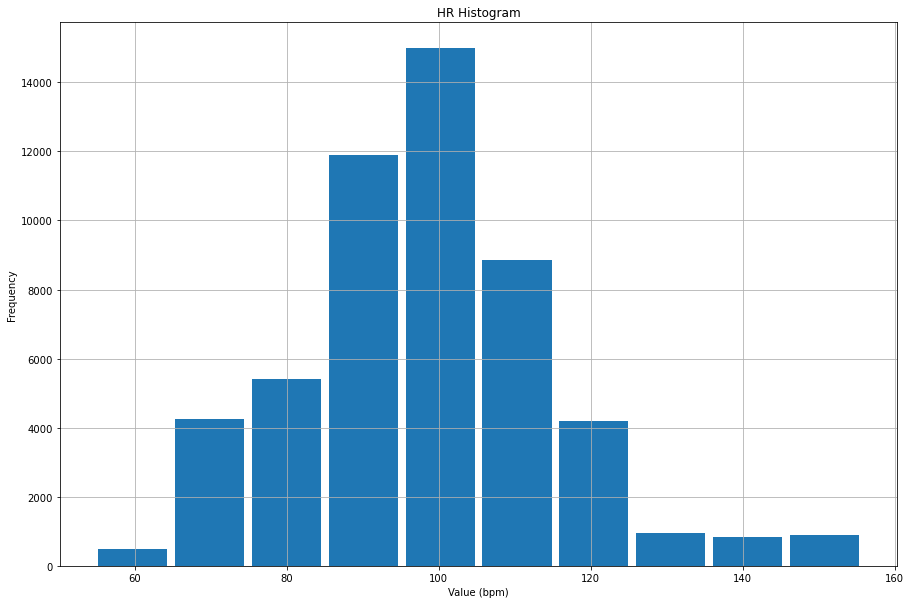

In [18]:
# Plotting the distributions of SBP, DBP, MAP, and HR
import matplotlib.pyplot as plt
data_to_plot = 'HR'
title_dist = data_to_plot + " Histogram"
plt.rcParams["figure.figsize"]=15,10
Data_intervals_minutes = All_Instants_Data[data_to_plot]
Data_intervals_minutes.hist(rwidth=0.9)
plt.title(title_dist)
plt.xlabel("Value (bpm)");
plt.ylabel("Frequency");
plt.savefig(title_dist+'.svg', format='svg', dpi=1200)

## Regression (Train & Test Results, Accuracies, and Statistics)

C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

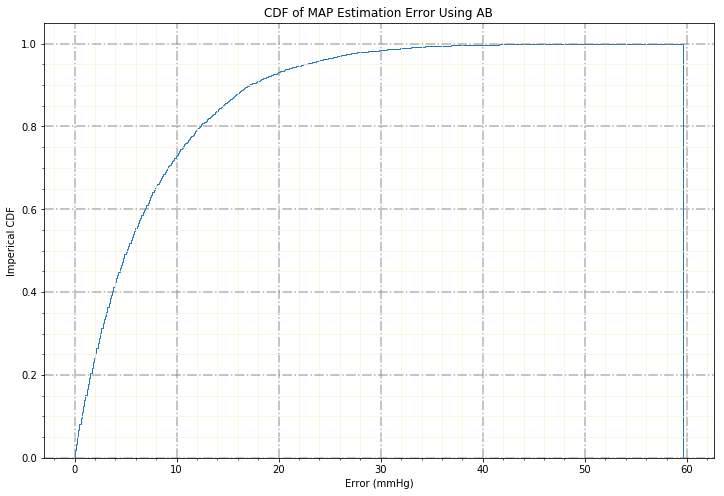

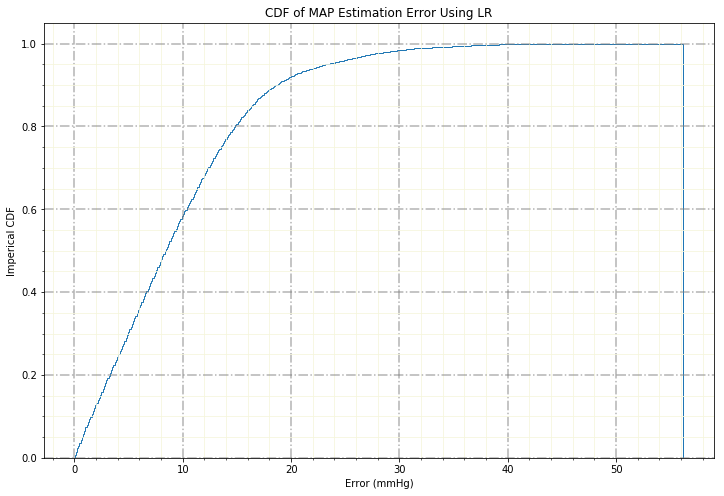

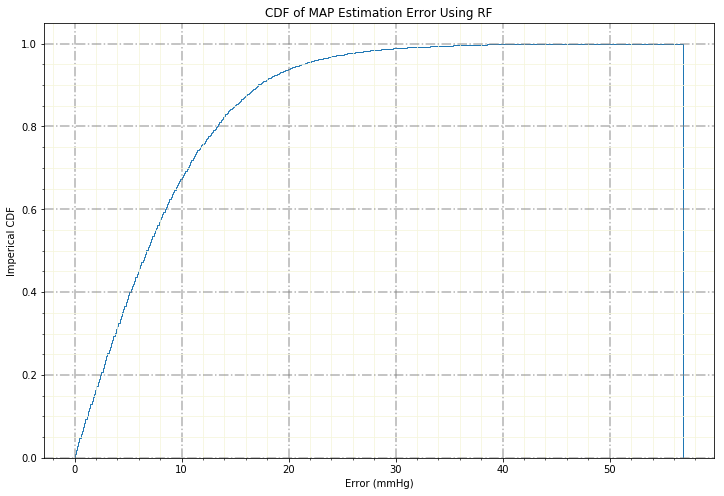

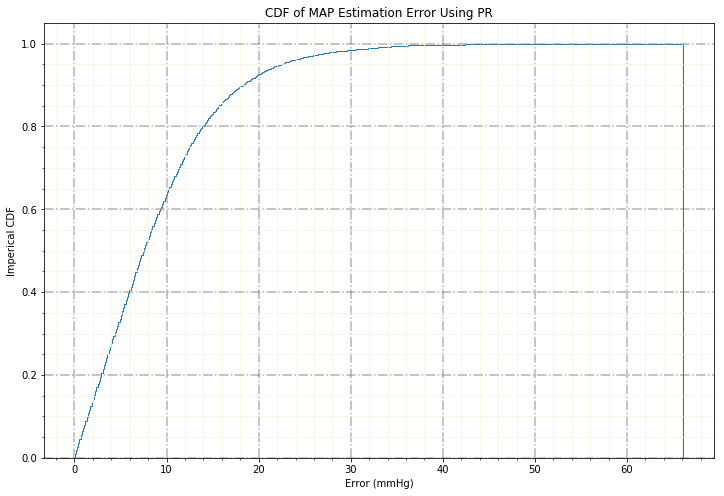

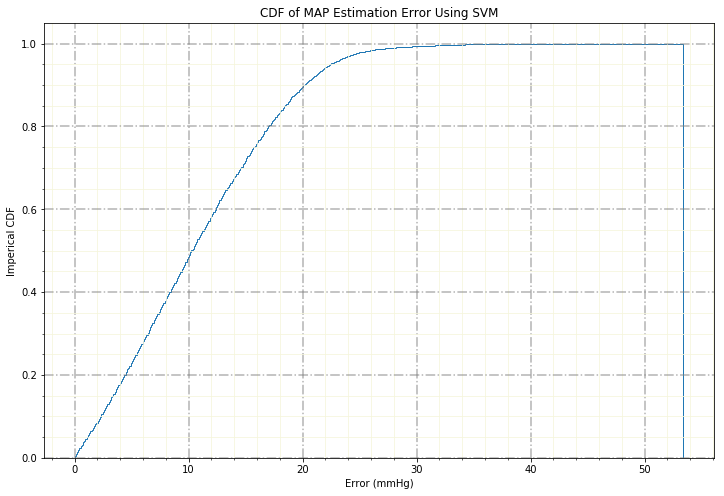

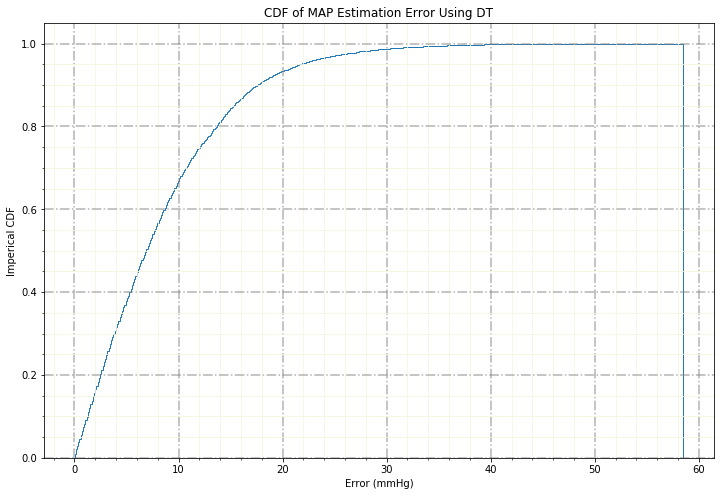

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")


TARGET = 'MAP' # SBP or DBP or MAP
Reg_Model_vec = ['AB', 'LR', 'RF', 'PR', 'SVM', 'DT']


######################################################################
# Data Shuffling and Scaling
do_scaling = 0
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)

# Data Scaling
if do_scaling == 1:
    train_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr)),
            ('std_scaler', StandardScaler()),
    ])
    train_copy2_tr = train_pipeline.fit_transform(train_copy2_tr) # now it is a complete matrix, mean=0, var=1
    # Preparing Test Data:
    test_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr)),
            ('std_scaler', StandardScaler()),
    ])
    test_copy_tr = test_pipeline.fit_transform(test_copy_tr)
######################################################################


#DaTime = str(datetime.today().strftime('%Y%m%d-%H:%M'))
DaTime = ""
Results_file = TARGET+'_Results_'+ DaTime +'.txt'


for Reg_Model in Reg_Model_vec:
    Save_Code = 0 # default, unless enabled within alg
    
    # Setting Models', Var's, Files', and Graphs' names to be saved
    Code_file = TARGET + '_Code_' + Reg_Model + DaTime +'.txt'
    CDF_file = TARGET + '_Error_CDF_' + Reg_Model + DaTime +'.svg'
    Model_file = TARGET + '_Model_' + Reg_Model + DaTime +'.pkl'
    Train_Error_file = TARGET + '_Train_Error_' + Reg_Model + DaTime +'.pkl'
    Test_Error_file = TARGET + '_Test_Error_' + Reg_Model + DaTime +'.pkl'
    ######################################
    
    # Regression Model:
    
    #      Linear Regression
    if Reg_Model == "LR":
        lin_reg = LinearRegression()
        lin_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = lin_reg.predict(test_copy_tr)
        Train_Predictions = lin_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(lin_reg)
        joblib.dump(lin_reg, Model_file)
        
    #      Random Forest
    if Reg_Model == "RF":
        forest_reg = RandomForestRegressor(n_estimators=64, max_leaf_nodes=128, min_samples_leaf=100) #64, 128, 100
        forest_reg.fit(train_copy2_tr, train_labels)
        Test_Predictions = forest_reg.predict(test_copy_tr)
        Train_Predictions = forest_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(forest_reg)
        joblib.dump(forest_reg, Model_file)
        
    if Reg_Model == "AB":
        AB_reg = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes=2*4096, min_samples_leaf=1),n_estimators=1024)
        AB_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = AB_reg.predict(test_copy_tr)
        Train_Predictions = AB_reg.predict(train_copy2_tr)
        #joblib.dump(AB_reg, Model_file) # REMOVED IT BECAUSE IT IS > 1 GB
        
    if Reg_Model == "PR":
        deg_p = 10
        poly_features = PolynomialFeatures(degree=deg_p, include_bias=False)
        X_poly = poly_features.fit_transform(train_copy2_tr)
        poly_lin_reg = LinearRegression()
        poly_lin_reg.fit(X_poly, train_labels)
        Test_Predictions = poly_lin_reg.predict(poly_features.fit_transform(test_copy_tr)) 
        Train_Predictions = poly_lin_reg.predict(X_poly)
        joblib.dump(poly_lin_reg, Model_file)
    
    if Reg_Model == "DT":
        DT_reg = DecisionTreeRegressor(max_leaf_nodes=256, min_samples_leaf=200)
        DT_reg.fit(train_copy2_tr, train_labels)    
        Test_Predictions = DT_reg.predict(test_copy_tr)
        Train_Predictions = DT_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(DT_reg)
        joblib.dump(DT_reg, Model_file)
    
    if Reg_Model == "SVM":
        SVM_reg = LinearSVR(epsilon=1.5) # was 1.5 with MAE=8.293
        SVM_reg.fit(train_copy2_tr, train_labels)
        Test_Predictions = SVM_reg.predict(test_copy_tr)
        Train_Predictions = SVM_reg.predict(train_copy2_tr)
        Save_Code = 1
        code = m2c.export_to_c(SVM_reg)
        joblib.dump(SVM_reg, Model_file)
    
    
    # Errors, ME, MAE, std Calculations:
    Train_Error = train_labels - Train_Predictions
    Test_Error = test_labels - Test_Predictions
    Train_ME = np.mean(Train_Error)
    Test_ME = np.mean(Test_Error)
    Train_std = np.std(Train_Error)
    Test_std = np.std(Test_Error)
    Test_MAE = np.mean(abs(Test_Error))
    Train_MAE = np.mean(abs(Train_Error))
    joblib.dump(Train_Error, Train_Error_file)
    joblib.dump(Test_Error, Test_Error_file)
    
    
    # Writing Results in Text File: 
    textfile = open(Results_file, 'a')
    textfile.write('Results for ' + Reg_Model + '\n')
    textfile.write('Test ME: ' + str(Test_ME) + ' , Train ME: ' + str(Train_ME) + '\n')
    textfile.write('Test Std: ' + str(Test_std) + ' , Train Std: ' + str(Train_std) + '\n')
    textfile.write('Test MAE: ' + str(Test_MAE) + ', Train MAE: ' + str(Train_MAE) + '\n')
    textfile.write('=========================================' + '\n')
    textfile.close()
    
    
    # Saving C Code for some models (LR, DT, SVM, RF)
    if Save_Code == 1:
        textfile = open(Code_file, 'w')
        textfile.write(code)
        textfile.close()
    
    
    # Plot & Save CDF of Error
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.savefig(CDF_file, format='svg', dpi=1200)

Results for LRComparing Test(saved model), Train(train on spot), Calc(use eqn)

Test ME: 0.07323293924947366 , Train ME: 0.07323293924873378 , Calc ME: 0.07323293924873378

Test Std: 20.356507007643895 , Train Std: 20.356507007643017 , Calc Std: 20.356507007643017

Test MAE: 16.70278118805816, Train MAE: 16.70278118805666, Calc MAE: 16.70278118805666




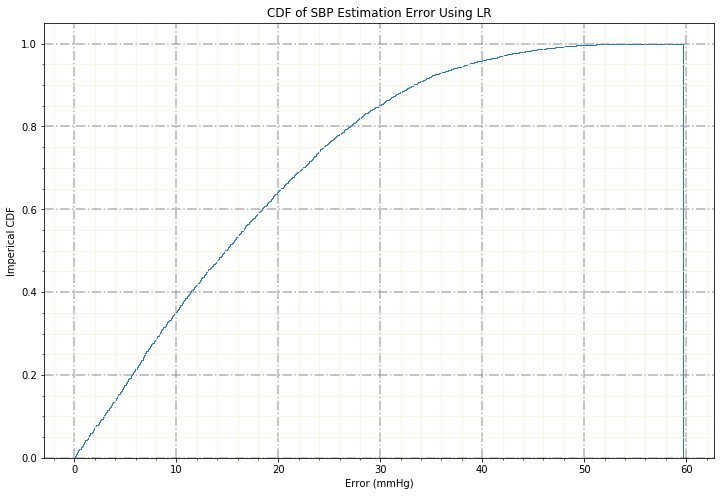

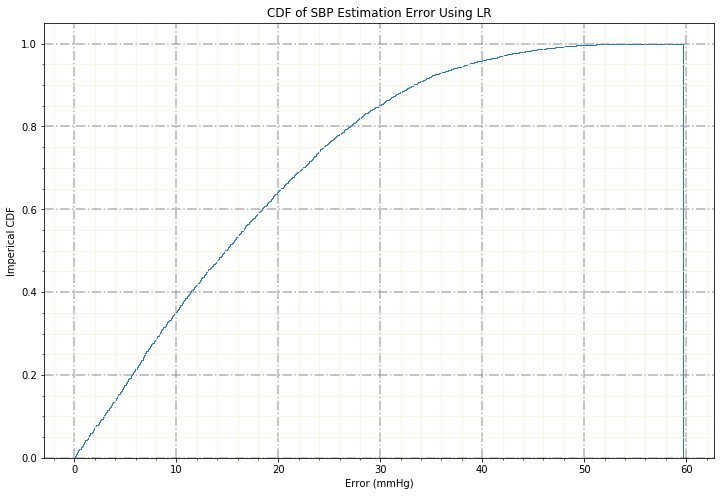

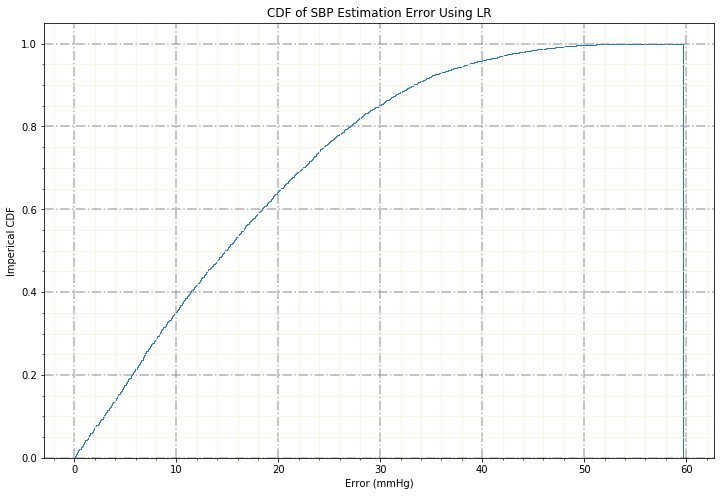

In [142]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")


TARGET = 'SBP' # SBP or DBP or MAP
Reg_Model_vec = ['LR']
round_digits = 10

######################################################################
# Data Shuffling and Scaling
do_scaling = 0
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)


    ######################################
x=[1]
for i in x:    
    C_Outputs = pd.DataFrame()
    Train_Predictions = pd.DataFrame()
    lin_reg2 = LinearRegression()
    lin_reg2.fit(train_copy2_tr, train_labels)  
    for i in range(len(test_copy_tr.index)):
        
        #new_list = [[test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]]] 
        #new_list = [[test_copy_tr['PTTh'].iloc[i].round(round_digits), test_copy_tr['PTTm'].iloc[i].round(round_digits), test_copy_tr['PTT'].iloc[i].round(round_digits), test_copy_tr['HR'].iloc[i].round(round_digits)]] 
        new_list = np.array(test_copy_tr.iloc[i])
        #Pred = test_pred(new_list)
        Pred = test_pred2(new_list)
        
        Subset_DF = pd.DataFrame({'Pred':[Pred.round(round_digits)]})
        C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
        
        Pred2 = lin_reg2.predict([new_list])
        Subset_DF2 = pd.DataFrame({'Pred':[Pred2[0].round(round_digits)]})
        Train_Predictions = Train_Predictions.append(Subset_DF2, ignore_index=True)
        
    #lin_reg = joblib.load('C:/1_Work/FANOS_lab/KA/KA/temp_downloads/results/Finalizing Results/SBP/SBP_Model_LR.pkl')
    lin_reg = lin_reg2 ############################## NOW USING THE EXACT SAME MODEL!!!  
    Test_Predictions = lin_reg.predict(test_copy_tr.values.round(round_digits))
    #Train_Predictions = lin_reg2.predict(test_copy_tr)

    
    # Errors, ME, MAE, std Calculations:
    Train_Error = test_labels.values.round(round_digits) - Train_Predictions['Pred'].values.round(round_digits)
    Test_Error = test_labels.values.round(round_digits) - Test_Predictions.round(round_digits)
    Calc_Error = test_labels.values.round(round_digits) - C_Outputs['Pred'].values.round(round_digits)
    
    Train_ME = np.mean(Train_Error)
    Test_ME = np.mean(Test_Error)
    Calc_ME = np.mean(Calc_Error)
    
    Train_std = np.std(Train_Error)
    Test_std = np.std(Test_Error)
    Calc_std = np.std(Calc_Error) 
    
    Test_MAE = np.mean(abs(Test_Error))
    Train_MAE = np.mean(abs(Train_Error))
    Calc_MAE = np.mean(abs(Calc_Error))
    
    
    print('Results for ' + Reg_Model + 'Comparing Test(saved model), Train(train on spot), Calc(use eqn)' + '\n')
    print('Test ME: ' + str(Test_ME) + ' , Train ME: ' + str(Train_ME) + ' , Calc ME: ' + str(Calc_ME) +'\n')
    print('Test Std: ' + str(Test_std) + ' , Train Std: ' + str(Train_std) + ' , Calc Std: ' + str(Calc_std) + '\n')
    print('Test MAE: ' + str(Test_MAE) + ', Train MAE: ' + str(Train_MAE) +', Calc MAE: ' + str(Calc_MAE) + '\n')
    print('=========================================' + '\n')
    
    
    
    # Plot & Save CDF of Error
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    #plt.savefig(CDF_file, format='svg', dpi=1200)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Train_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Calc_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)

In [54]:
C_Outputs.size

10543

In [144]:
np.std(Test_Predictions)

4.702140431320385

In [9]:
x=joblib.load('C:/1_Work/FANOS_lab/KA/KA/temp_downloads/results/Finalizing Results/SBP/SBP_Model_LR.pkl')


In [51]:
lin_reg.coef_

array([ 5.56047664, -0.83717347, -0.48828559, -0.22598764])

In [52]:
lin_reg2.coef_

array([ 5.56047664, -0.83717347, -0.48828559, -0.22598764])

In [121]:
test_copy_tr.iloc[0]

PTTh      1.889763
PTTm      0.455385
PTT       0.038857
HR      101.024056
Name: 261136, dtype: float64

In [124]:
test_labels.values

array([142.68153846, 126.50071429, 103.80666667, ...,  84.9736    ,
       104.95181818,  89.21476923])

In [136]:
x = pd.DataFrame()
x['Train_Predictions'] = Train_Predictions['Pred'].values
x['Test_Predictions'] = Test_Predictions
x['Test_labels'] = test_labels.values
x['Train_Error'] = test_labels.values - Train_Predictions['Pred']
x['Test_Error'] = test_labels.values - Test_Predictions
x

,Train_Predictions,Test_Predictions,Test_labels,Train_Error,Test_Error
0,132.037,132.038764,142.681538,10.644538,10.642775
1,129.701,129.701260,126.500714,-3.200286,-3.200546
2,133.987,133.988130,103.806667,-30.180333,-30.181464
3,128.065,128.065471,97.229067,-30.835933,-30.836404
4,131.156,131.157176,94.126308,-37.029692,-37.030868
5,134.219,134.219225,115.516615,-18.702385,-18.702609
6,136.002,136.000220,125.641000,-10.361000,-10.359220
7,128.621,128.623549,145.818182,17.197182,17.194633
8,133.429,133.429304,136.900833,3.471833,3.471529
9,123.535,123.536778,116.948571,-6.586429,-6.588206


In [70]:
pred3 = lin_reg.predict([[0.4580118181818182,
  0.5767272727272728,
  0.17933333333333332,
  96.00279280851808]])

In [76]:
float(pred3[0])

125.04052786828034

In [6]:
import m2cgen as m2c
print(m2c.export_to_c(lin_reg))

double score(double * input) {
    return ((((144.7595952135736) + ((input[0]) * (5.560476637951604))) + ((input[1]) * (-0.8371734744260986))) + ((input[2]) * (-0.4882855887343618))) + ((input[3]) * (-0.22598764128164273));
}



In [49]:
def test_pred(input):
    return ((((144.7595952135736) + ((input[0][0]) * (5.560476637951604))) + ((input[0][1]) * (-0.8371734744260986))) + ((input[0][2]) * (-0.4882855887343618))) + ((input[0][3]) * (-0.22598764128164273))

In [117]:
def test_pred2(input):
    return ((((144.7595952135736) + ((input[0]) * (5.560476637951604))) + ((input[1]) * (-0.8371734744260986))) + ((input[2]) * (-0.4882855887343618))) + ((input[3]) * (-0.22598764128164273))

In [39]:
out1 = (10000000000000000000*(10000000000000000000*lin_reg.predict([[1,1,1,1]]) - 10000000000000000000*test_pred([[1,1,1,1]])))
if out1==0:
    print("Same Result")

Same Result


In [15]:
test_labels

261136     97.009515
85333     100.962043
278229     76.319866
208762     78.480038
221465     78.192719
115903     81.376381
328025     90.438284
164730     94.794978
147364    101.401436
4272       83.745138
107515     77.924880
230525     85.246529
257071     93.385604
146325    108.353194
117372     89.960175
173586     77.047001
255287    106.061043
76119     118.144698
124793    121.383264
239425     86.419068
85245      81.561029
239918     84.276224
319245     96.645198
24188      83.320800
82162      87.676824
213276     84.144476
190268     96.970434
197328    104.162793
115473     99.321938
81257      85.373035
             ...    
152640    105.301828
81852      85.883759
304140     74.286434
83344      76.163839
114839    116.228614
139740     80.856789
200177     81.526068
213551     82.410366
119784    108.300638
80289      74.234382
216358     88.640118
228289     93.433659
149756     95.425302
39483      95.821532
32657      76.949380
131076     90.303142
189852     85

In [16]:


MAP_predicted = ((((90.99430232384626) + ((test_copy_tr['PTTh']) * (1.3225782934193493))) + ((test_copy_tr['PTTm']) * (-1.636202923220917))) + ((test_copy_tr['PTT']) * (5.547629507294542))) + ((test_copy_tr['HR']) * (-0.005001368935667383))

print(np.mean(abs(MAP_predicted - test_labels)))

9.657400999030935


In [ ]:
def recvFromArduino():
  global startMarker, endMarker
  
  ck = ""
  x = "z" # any value that is not an end- or startMarker
  byteCount = -1 # to allow for the fact that the last increment will be one too many
  
  # wait for the start character
  while  ord(x) != startMarker: 
    x = ser.read()
  
  # save data until the end marker is found
  while ord(x) != endMarker:
    if ord(x) != startMarker:
      ck = ck + x.decode('utf-8')
      byteCount += 1
    x = ser.read()
  
  
  return(ck) 

###########################################################

str_from_MCU = recvFromArduino()
      chunks = str_from_MCU.split(',')
      P_SBP = float(chunks[0])
      P_DBP = float(chunks[1])
      infTime = int(chunks[2]) 
      
      Subset_DF = pd.DataFrame({'Pred_SBP':[P_SBP],'Pred_DBP':[P_DBP],'Inf_Time':[infTime]})
      MCU_pred = MCU_pred.append(Subset_DF, ignore_index=True)
    
#############################################################
allData =  pd.read_csv('UPDATED_Extracted_Instants_Parameters.csv')
cols = ['PTT','HR','SBP','DBP']
Total_length = len(allData.index)


#testData = allData.loc[8*Total_length//10:,cols] # This shall consider all test points
testData = allData.loc[8*Total_length//10:(8*Total_length//10)+Num_Test_Points,cols] #################### index !!!

PackedDataList = [] # THAT IS A LIST APPARENTLY!
for i in range(len(testData.index)):
    new_str = '<' + str(testData['PTT'].iloc[i]) + ',' + str(testData['HR'].iloc[i]) + '>'
    PackedDataList.append(new_str) 


Predictions_df = runTest(PackedDataList)  

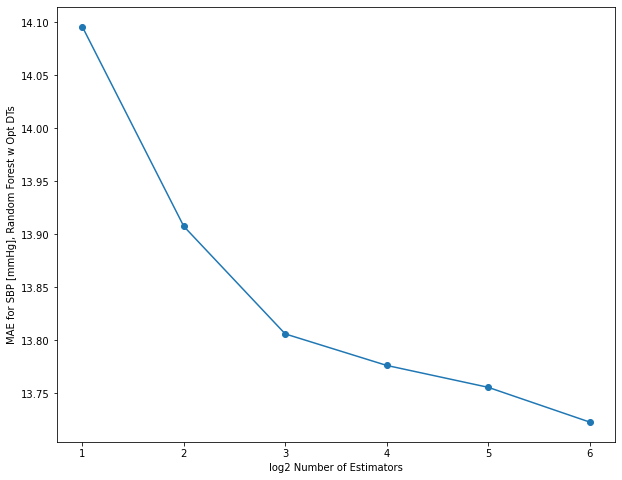

In [72]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor

N_estimator_vec = [2, 4, 8, 16, 32, 64]
MAE_FR_vec = [0]*len(N_estimator_vec)

for Nes in range(len(N_estimator_vec)):
    forest_reg = RandomForestRegressor(n_estimators=N_estimator_vec[Nes], max_leaf_nodes=256, min_samples_leaf=50) #msl = 100 .. 50 is better
    forest_reg.fit(train_copy2_tr, train_labels)
    FR_Predictions = forest_reg.predict(test_copy_tr)
    MAE_FR_vec[Nes] = np.mean(abs(test_labels - FR_Predictions))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for SBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(N_estimator_vec), MAE_FR_vec,'-o')
plt.show()

## Ensample learning: 

In [ ]:
# Ensample learning: 

# Voting (diverse over techniqes) SHOULD I TRY IT OVER THE ALGORITHM I AM ALREADY USING? 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
        estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard'
    )
voting_clf.fit(X_train, y_train)


# Bagging & Pasting (diverse over training data)
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples=100, bootstrap=True, n_jobs=-1
    )
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

### 3.1 Shuffle & Split data between Train & Test

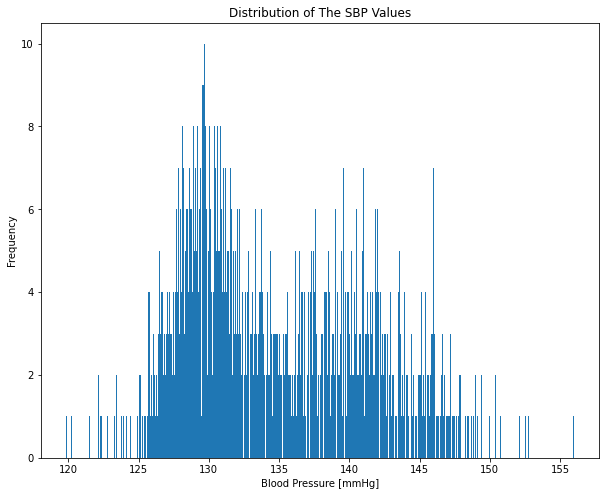

In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,8
Data_intervals_minutes = All_Instants_Data['SBP']
Data_intervals_minutes.plot(kind='hist', bins=500)
plt.xlabel("Blood Pressure [mmHg]");
plt.title("Distribution of The SBP Values");

<AxesSubplot:ylabel='Frequency'>

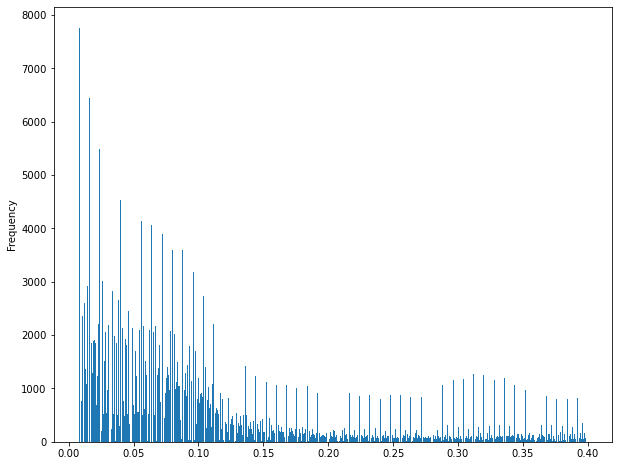

In [116]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,8
Data_intervals_minutes = All_Instants_Data['PTT']
Data_intervals_minutes.plot(kind='hist', bins=600)

In [117]:
All_Instants_Data.describe()

,PTT,HR,SBP,DBP
count,291898.000000,291898.000000,291898.000000,291898.000000
mean,0.108580,102.206733,129.532260,71.519072
std,0.099083,14.842666,20.305008,9.927287
min,0.008000,54.644809,80.006500,60.000000
25%,0.038000,93.530787,114.804000,64.102800
50%,0.076000,101.522843,128.398000,68.780200
75%,0.136000,111.255331,143.700000,76.453250
max,0.398857,155.792129,180.000000,129.960000


### 3.2 Pipelines for Data Cleansing (replaced temporarily, may reuse for scaling)

In [3]:

#%% Preprocessing Train & Test Data:
# Preparing Train Data:
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
train_pipeline = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr)),
        ('std_scaler', StandardScaler()),
    ])
train_copy2_tr = train_pipeline.fit_transform(train_copy2_tr) # now it is a complete matrix, mean=0, var=1

# Preparing Test Data:
test_pipeline = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr)),
        ('std_scaler', StandardScaler()),
    ])
test_copy_tr = test_pipeline.fit_transform(test_copy_tr)

## 4) Learning & Testing & Evaluation using different models:

### 4.0 Regulated Models

#### 4.0.1 Ridge Regression

In [7]:

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(train_copy2_tr, train_labels)
ridge_Predictions = ridge_reg.predict(test_copy_tr)

from sklearn.metrics import mean_squared_error
ridge_mse = mean_squared_error(test_labels, ridge_Predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_MAE = np.mean(abs(test_labels - ridge_Predictions))
print("Ridge Regression has RMSE: ",ridge_rmse, " and MAE: ", ridge_MAE)
print("Training MAE: ", np.mean(abs(train_labels - ridge_reg.predict(train_copy2_tr))), "Test MAE: ", ridge_MAE)

Ridge Regression has RMSE:  5.64887375783416  and MAE:  4.57845094080368
Training MAE:  4.74194391883461 Test MAE:  4.57845094080368


#### 4.0.2 Polynomial Regression

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np
deg_p = 2
poly_features = PolynomialFeatures(degree=deg_p, include_bias=False)
X_poly = poly_features.fit_transform(train_copy2_tr)
poly_lin_reg = LinearRegression()
poly_lin_reg.fit(X_poly, train_labels)
poly_LR_Predictions= poly_lin_reg.predict(poly_features.fit_transform(test_copy_tr)) # should the test data be poly as well??
#lin_reg.intercept_, lin_
from sklearn.metrics import mean_squared_error
poly_LR_mse = mean_squared_error(test_labels, poly_LR_Predictions)
poly_LR_rmse = np.sqrt(poly_LR_mse)
poly_MAE = np.mean(abs(test_labels - poly_LR_Predictions))
print("Polynomial Regression of degree: ", deg_p, " has RMSE: ",poly_LR_rmse, " and MAE: ", poly_MAE)

Polynomial Regression of degree:  2  has RMSE:  5.665344823447999  and MAE:  4.529749295487399


In [9]:
# Regulated polynomial regression -- using Ridge with Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
import numpy as np
# prepare polynomial
deg_p = 2
alp = 100 # was 1 .. it looks like it does not matter for the second degree! 
poly_features = PolynomialFeatures(degree=deg_p, include_bias=False)
X_poly = poly_features.fit_transform(train_copy2_tr)
# ridge regression using the polynomial features
poly_ridge_reg = Ridge(alpha=alp, solver="cholesky")
poly_ridge_reg.fit(X_poly, train_labels)
poly_ridge_Predictions = poly_ridge_reg.predict(poly_features.fit_transform(test_copy_tr)) 

from sklearn.metrics import mean_squared_error
poly_ridge_mse = mean_squared_error(test_labels, poly_ridge_Predictions)
poly_ridge_rmse = np.sqrt(poly_ridge_mse)
poly_ridge_MAE = np.mean(abs(test_labels - poly_ridge_Predictions))
print("Polynomial Ridge Regression of degree: ", deg_p, " has RMSE: ",poly_ridge_rmse, " and MAE: ", poly_ridge_MAE)
print("Training MAE: ", np.mean(abs(train_labels - poly_ridge_reg.predict(X_poly))), "Test MAE: ", poly_ridge_MAE)

Polynomial Ridge Regression of degree:  2  has RMSE:  5.5966838347516505  and MAE:  4.5196822520459845
Training MAE:  4.635697540375938 Test MAE:  4.5196822520459845


#### 4.0.3 Regulated Decision Trees

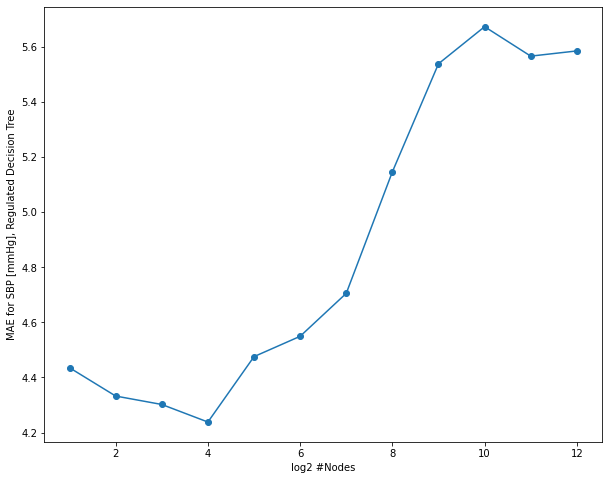

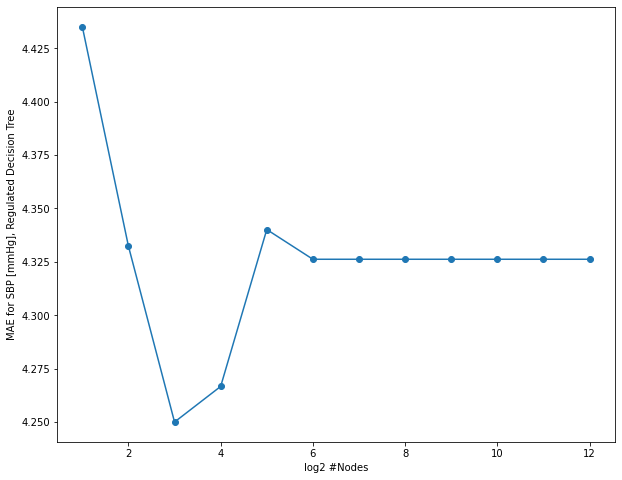

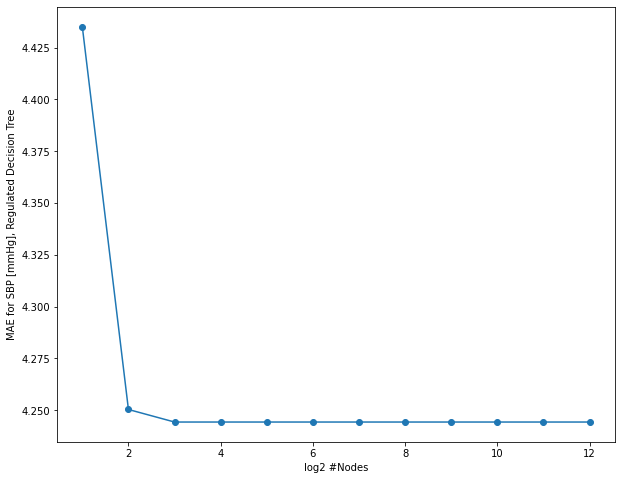

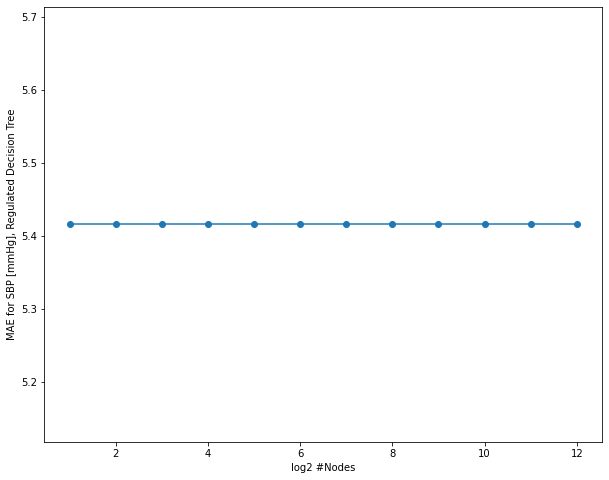

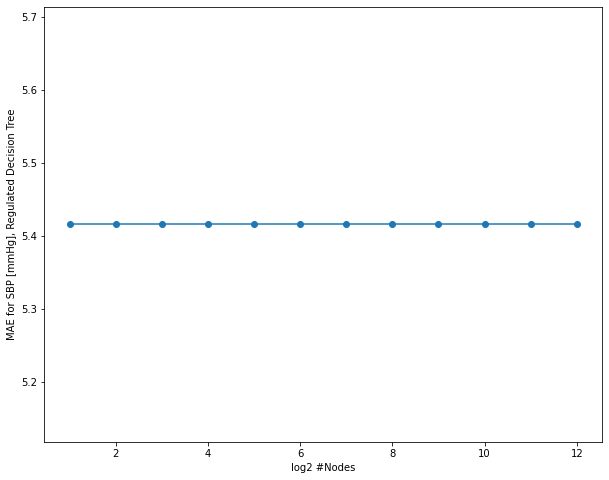

In [10]:
#min_samples_leaf=10

min_samples_vec = [1,10,100,500,1000]

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

Nodes = [2,4,8,16,32,64,128,256,512,1024,2048,4096]

for k in min_samples_vec:
    MAE_TR = [0]*len(Nodes)
    TR_Error = pd.DataFrame()
    
    for i in range(len(Nodes)):
        # Create Model
        file_name = "SBP_DT_"+str(Nodes[i])+"_Nodes"
        tree_reg = DecisionTreeRegressor(max_leaf_nodes=Nodes[i],min_samples_leaf=k) 
        tree_reg.fit(train_copy2_tr, train_labels)
        TR_Predictions = tree_reg.predict(test_copy_tr)
        
        # Calculate Prediction Errors & MAE
        error_TR = abs(test_labels - TR_Predictions)
        TR_Error[str(Nodes[i])] = error_TR
        MAE_TR[i] = np.mean(error_TR)
    
    #print("min samples leaf: ", k, " MAE", MAE_TR)
    # Now plot MAE's
    plt.rcParams["figure.figsize"]=10,8
    plt.xlabel('log2 #Nodes')
    plt.ylabel('MAE for SBP [mmHg], Regulated Decision Tree')
    plt.plot(np.log2(Nodes),MAE_TR,'-o')
    plt.show()


### 4.1 Linear Regression

In [55]:
#%% Learning & Testing & Evaluation using different models:
import numpy as np
#    1) Linear Regression:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(train_copy2_tr, train_labels)     # Model trained! 
LR_Predictions= lin_reg.predict(test_copy_tr)
from sklearn.metrics import mean_squared_error
LR_mse = mean_squared_error(test_labels, LR_Predictions)
LR_rmse = np.sqrt(LR_mse)
LR_MAE = np.mean(abs(test_labels - LR_Predictions))
print("Linear Regression RMSE: ",LR_rmse, " and MAE: ", LR_MAE)
print("Training MAE: ", np.mean(abs(train_labels - lin_reg.predict(train_copy2_tr))), "Test MAE: ", LR_MAE)

Linear Regression RMSE:  20.356638735695466  and MAE:  16.702781188057052
Training MAE:  16.549799941137 Test MAE:  16.702781188057052


### 4.2 Decision Tree

In [12]:
#    2) DecisionTreeRegressor: More powerful & models non-linearities 
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_leaf_nodes=256, min_samples_leaf=100) #########################################
tree_reg.fit(train_copy2_tr, train_labels)
TR_Predictions = tree_reg.predict(test_copy_tr)
TR_mse = mean_squared_error(test_labels, TR_Predictions)
TR_rmse = np.sqrt(TR_mse)
TR_MAE = np.mean(abs(test_labels - TR_Predictions))
print("DecisionTree Regression RMSE: ",TR_rmse, " and MAE: ", TR_MAE)
print("Training MAE: ", np.mean(abs(train_labels - tree_reg.predict(train_copy2_tr))), "Test MAE: ", TR_MAE)

DecisionTree Regression RMSE:  5.418244815097818  and MAE:  4.244340825586969
Training MAE:  4.286387509053233 Test MAE:  4.244340825586969


### 4.3 Random Forest

In [32]:
np.mean(abs(test_labels - FR_Predictions))

14.688167833520257

In [24]:
import joblib
joblib.dump(forest_reg,"forest_reg_4trees_16nodes_0402.pkl")

['forest_reg_4trees_16nodes_0402.pkl']

### 4.4 SVM

#### 4.4.1 Linear SVM

In [9]:
#    4) SVM: Support Vector Machine (Linear and Non-Linear)
# Linear SVM
from sklearn.svm import LinearSVR
SVM_reg = LinearSVR(epsilon=5) # epsilon=.1 but 5 is better (MAE 14.0119)! 
SVM_reg.fit(train_copy2_tr, train_labels)
SVM_Predictions = SVM_reg.predict(test_copy_tr)
SVM_mse = mean_squared_error(test_labels, SVM_Predictions)
SVM_rmse = np.sqrt(SVM_mse)
SVM_MAE = np.mean(abs(test_labels - SVM_Predictions)) 
print("Linear SVM RMSE: ",SVM_rmse, " & MAE: ",SVM_MAE)


Linear SVM RMSE:  20.044143627899075  & MAE:  16.29303670244896


#### 4.4.2 Polynomial SVM

In [72]:
from sklearn.svm import SVR
SVM_poly_reg = SVR(kernel="poly", degree=3, C=60, epsilon=1, coef0=1)
# coef0 controls how much the model is influenced by highdegree polynomials vs low-degree polynomials.
SVM_poly_reg.fit(train_copy2_tr, train_labels)
SVM_poly_Predictions = SVM_poly_reg.predict(test_copy_tr)
SVM_poly_mse = mean_squared_error(test_labels, SVM_poly_Predictions)
SVM_poly_rmse = np.sqrt(SVM_poly_mse)
SVM_poly_MAE = np.mean(abs(test_labels - SVM_poly_Predictions)) 
print("SVM with kernel Regression RMSE: ",SVM_poly_rmse, " & MAE: ",SVM_poly_MAE)


SVM with kernel Regression RMSE:  17.045349003312722  & MAE:  13.413558848066428


## Check Error CDF for the best Alg (for Grade A,B,C)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


(array([0.02905148, 0.05797327, 0.08609095, 0.11347587, 0.14137956,
        0.16976311, 0.19823746, 0.22555104, 0.25433665, 0.28207173,
        0.30929453, 0.33569377, 0.36165204, 0.38665707, 0.41201875,
        0.43682275, 0.46086804, 0.48436213, 0.50751253, 0.52967726,
        0.55155665, 0.57300158, 0.59344137, 0.6135699 , 0.63277111,
        0.65132385, 0.67014895, 0.68838395, 0.70593805, 0.7227918 ,
        0.73939913, 0.75567574, 0.77204314, 0.78767128, 0.80363662,
        0.81860332, 0.83275944, 0.84547594, 0.85771907, 0.86852259,
        0.87904727, 0.88885863, 0.89761298, 0.90603013, 0.91355239,
        0.92063369, 0.92678119, 0.93244882, 0.93766252, 0.94257793,
        0.94652063, 0.95058006, 0.95388726, 0.95690913, 0.95962622,
        0.96231089, 0.96469078, 0.96718739, 0.96952837, 0.97168777,
        0.97367209, 0.97550078, 0.97737486, 0.979223  , 0.98092848,
        0.98234863, 0.98371042, 0.98481282, 0.98612273, 0.98721864,
        0.98844425, 0.9896115 , 0.99048045, 0.99

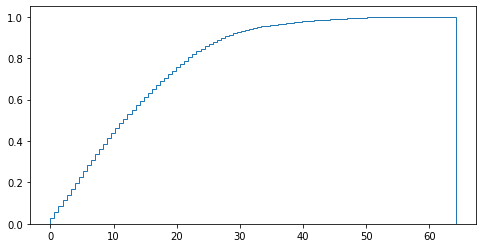

In [37]:
Error_LR = abs(test_labels - LR_Predictions)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(Error_LR, 100, normed=1, histtype='step', cumulative=True, label='Empirical')

In [19]:
import joblib
# Saving SBP Estimation Models:
joblib.dump(lin_reg,"lin_reg0324.pkl")
joblib.dump(tree_reg,"tree_reg_4nodes_0402.pkl")
joblib.dump(forest_reg,"forest_reg0324.pkl")
joblib.dump(SVM_reg,"SVM_reg0324.pkl")
#joblib.dump(,"0324.pkl")

# to load it, just use: xyz = joblib.load("model_name_as_saved.pkl")

['SVM_reg0324.pkl']

In [105]:
import joblib
# Saving SBP Estimation Models:

joblib.dump(SVM_reg,"SVM_SBP_best_13_9_0414.pkl")
#joblib.dump(,"0324.pkl")

# to load it, just use: xyz = joblib.load("model_name_as_saved.pkl")

['SVM_SBP_best_13_9_0414.pkl']

## 3) DBP Estimation

### 3.1 Load Data (if not loaded already from SBP part)

In [36]:
import pandas as pd
import numpy as np

take_log_PTT = 0
#################################################################################
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)

###### NEW FIXED DATA !!!!!!!!!! #################
All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_210609.csv')
#All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_NEW_FIXED_PTT_2021_05_18_Dist_40_3sec.csv') 
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP']]

## 4) Preparing Data for Regression [Predictive Models]

### 4.1 Splitting data between Train & Test -- This part assumes data loaded & outliers removed in SBP step

In [35]:
do_scaling = 0
# Better distribution of Train-Test data (homog over DBP)
Total_length = len(All_Instants_Data.index)
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
from sklearn.model_selection import train_test_split
train_copy2_tr_DBP, test_copy_tr_DBP, train_labels_DBP, test_labels_DBP = train_test_split(temp_data, All_Instants_Data['DBP'], test_size=0.2, random_state=42,shuffle=True)

if do_scaling == 1:
        train_pipeline = Pipeline([
                ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr_DBP)),
                ('std_scaler', StandardScaler()),
        ])
        train_copy2_tr_DBP = train_pipeline.fit_transform(train_copy2_tr_DBP) # now it is a complete matrix, mean=0, var=1
        # Preparing Test Data:
        test_pipeline = Pipeline([
                ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr_DBP)),
                ('std_scaler', StandardScaler()),
        ])
        test_copy_tr_DBP = test_pipeline.fit_transform(test_copy_tr_DBP)

For  ABRF Train MAE is:  3.566490881194794  and Test MAE is:  6.442737323520835


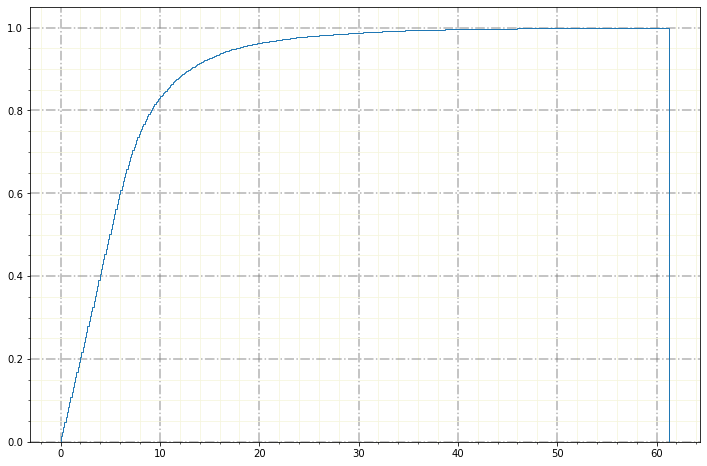

In [36]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np



Reg_Model_DBP = "ABRF"

if Reg_Model_DBP == "ABRF":
    #AB_reg = AdaBoostRegressor(RandomForestRegressor(n_estimators=128, max_leaf_nodes=4096, min_samples_leaf=1),n_estimators=8)
    AB_reg = AdaBoostRegressor(DecisionTreeRegressor(max_leaf_nodes=2*4096, min_samples_leaf=1),n_estimators=1024)
    ### Test MAE of 6.22 (train MAE 2.63) @ AB with DT max_leaf_nodes=4096, min_samples_leaf=1),n_estimators=1024
    ######### Test MAE of 6.03 @ AB with DT max_leag_nodes = 2*4096, min_samples_leaf=1, n_estimators = 1024
    AB_reg.fit(train_copy2_tr_DBP, train_labels_DBP)    
    Test_Predictions_DBP = AB_reg.predict(test_copy_tr_DBP)
    Train_Predictions_DBP = AB_reg.predict(train_copy2_tr_DBP)

if Reg_Model_DBP == "ABLR":
    AB_reg = AdaBoostRegressor(LinearRegression(),n_estimators=32*1024)
    AB_reg.fit(train_copy2_tr_DBP, train_labels_DBP)    
    Test_Predictions_DBP = AB_reg.predict(test_copy_tr_DBP)
    Train_Predictions_DBP = AB_reg.predict(train_copy2_tr_DBP)
    
if Reg_Model_DBP == "DT":
    DT_reg_DBP = DecisionTreeRegressor(max_leaf_nodes=256, min_samples_leaf=200)
    DT_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)    
    Test_Predictions_DBP = DT_reg_DBP.predict(test_copy_tr_DBP)
    Train_Predictions_DBP = DT_reg_DBP.predict(train_copy2_tr_DBP)
    
        
if Reg_Model_DBP == "PR":
    deg_p = 10
    poly_features_DBP = PolynomialFeatures(degree=deg_p, include_bias=False)
    X_poly_DBP = poly_features_DBP.fit_transform(train_copy2_tr_DBP)
    poly_lin_reg_DBP = LinearRegression()
    poly_lin_reg_DBP.fit(X_poly_DBP, train_labels_DBP)
    Test_Predictions_DBP = poly_lin_reg_DBP.predict(poly_features_DBP.fit_transform(test_copy_tr_DBP)) 
    Train_Predictions_DBP = poly_lin_reg_DBP.predict(X_poly_DBP)

Test_MAE_DBP = np.mean(abs(test_labels_DBP - Test_Predictions_DBP))
Training_MAE_DBP = np.mean(abs(train_labels_DBP - Train_Predictions_DBP))

print('For ', Reg_Model_DBP, 'Train MAE is: ', Training_MAE_DBP, ' and Test MAE is: ', Test_MAE_DBP)
Error_DBP = abs(Test_Predictions_DBP - test_labels_DBP);
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8));
ax.hist(Error_DBP, 500, density=1, histtype='step', cumulative=True, label='Empirical');
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)

In [75]:
np.mean(abs(Error_DBP))

6.0658556284487455

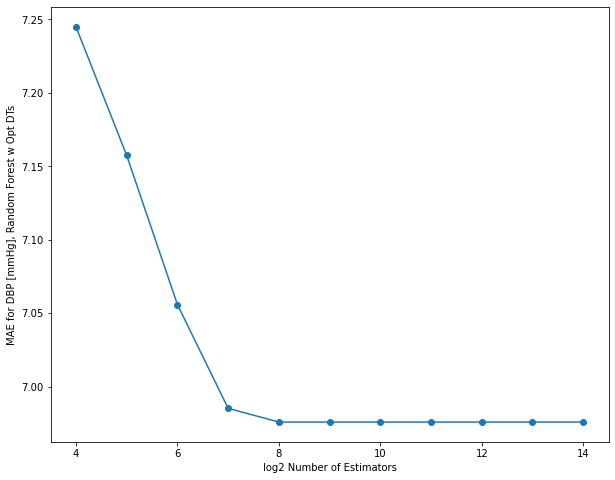

In [57]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

max_leaf_vec = [16,32,64,128,256, 512, 1024, 2048, 4096, 2*4096, 4*4096]
MAE_DT_vec_DBP = [0]*len(max_leaf_vec)

for Nl in range(len(max_leaf_vec)):
    DT_reg_DBP = DecisionTreeRegressor(max_leaf_nodes=max_leaf_vec[Nl], min_samples_leaf=200)
    DT_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)    
    Test_Predictions_DBP = DT_reg_DBP.predict(test_copy_tr_DBP)
    #Train_Predictions_DBP = DT_reg_DBP.predict(train_copy2_tr_DBP)
    MAE_DT_vec_DBP[Nl] = np.mean(abs(test_labels_DBP - Test_Predictions_DBP))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for DBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(max_leaf_vec), MAE_DT_vec_DBP,'-o')
plt.show()

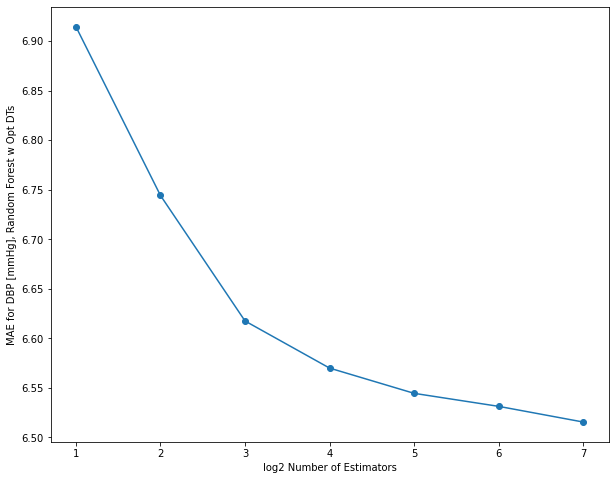

In [26]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
N_estimator_vec = [2, 4, 8, 16, 32, 64, 128]
MAE_FR_vec_DBP = [0]*len(N_estimator_vec)

for Nes in range(len(N_estimator_vec)):
    forest_reg_DBP = RandomForestRegressor(n_estimators=N_estimator_vec[Nes], max_leaf_nodes=4096, min_samples_leaf=1) #msl = 100 .. 50 is better
    forest_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
    FR_Predictions_DBP = forest_reg_DBP.predict(test_copy_tr_DBP)
    MAE_FR_vec_DBP[Nes] = np.mean(abs(test_labels_DBP - FR_Predictions_DBP))
#print("Random Forest Regression RMSE: ",FR_rmse, " & MAE: ",FR_MAE)
plt.rcParams["figure.figsize"]=10,8
plt.xlabel('log2 Number of Estimators')
plt.ylabel('MAE for DBP [mmHg], Random Forest w Opt DTs')
plt.plot(np.log2(N_estimator_vec), MAE_FR_vec_DBP,'-o')
plt.show()

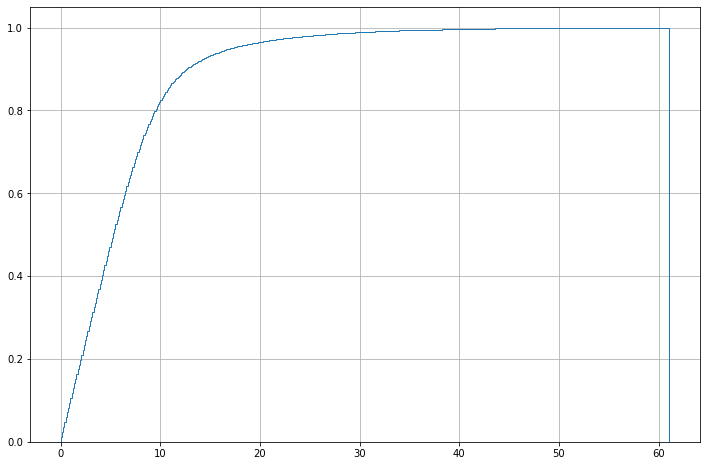

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_DBP = RandomForestRegressor(n_estimators=128, max_leaf_nodes=2048, min_samples_leaf=5) #msl = 100 .. 50 is better
forest_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
FR_Predictions_DBP = forest_reg_DBP.predict(test_copy_tr_DBP)
Error_FR_DBP = abs(test_labels_DBP - FR_Predictions_DBP);
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8));
ax.hist(Error_FR_DBP, 500, density=1, histtype='step', cumulative=True, label='Empirical');
plt.grid()

### 3.2 Pipelines for Data Cleansing 

In [61]:
#%% Preprocessing Train & Test Data:
# Preparing Train Data:
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
train_pipeline_DBP = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr_DBP)),
        ('std_scaler', StandardScaler()),
    ])
train_copy2_tr_DBP = train_pipeline_DBP.fit_transform(train_copy2_tr_DBP) # now it is a complete matrix, mean=0, var=1

# Preparing Test Data:
test_pipeline_DBP = Pipeline([
        ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr_DBP)),
        ('std_scaler', StandardScaler()),
    ])
test_copy_tr_DBP = test_pipeline_DBP.fit_transform(test_copy_tr_DBP)


## 4) Learning & Testing & Evaluation using different models:

### 4.1 Linear Regression

In [84]:
#%% Learning & Testing & Evaluation using different models:
import numpy as np
#    1) Linear Regression:
from sklearn.linear_model import LinearRegression
lin_reg_DBP = LinearRegression()
lin_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)     # Model trained! 
LR_Predictions_DBP= lin_reg_DBP.predict(test_copy_tr_DBP)
from sklearn.metrics import mean_squared_error
LR_mse_DBP = mean_squared_error(test_labels_DBP, LR_Predictions_DBP)
LR_rmse_DBP = np.sqrt(LR_mse_DBP)
LR_MAE_DBP = np.mean(abs(test_labels_DBP - LR_Predictions_DBP))
print("Linear Regression RMSE: ",LR_rmse_DBP, " & MAE: ", LR_MAE_DBP)

Linear Regression RMSE:  9.942138742034308  & MAE:  7.643920073614273


In [48]:
Error_LR_DBP = abs(test_labels_DBP - LR_Predictions_DBP);

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


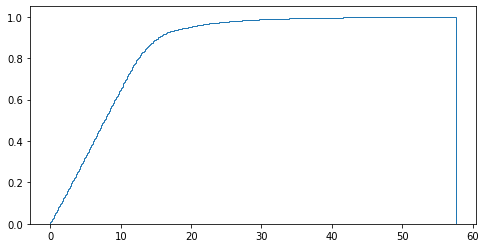

In [49]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4));
ax.hist(Error_LR_DBP, 500, normed=1, histtype='step', cumulative=True, label='Empirical');

### 4.2 Decision Tree

In [145]:
#    2) DecisionTreeRegressor: More powerful & models non-linearities 
from sklearn.tree import DecisionTreeRegressor
tree_reg_DBP = DecisionTreeRegressor()
tree_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
TR_Predictions_DBP = tree_reg_DBP.predict(test_copy_tr_DBP)
TR_mse_DBP = mean_squared_error(test_labels_DBP, TR_Predictions_DBP)
TR_rmse_DBP = np.sqrt(TR_mse_DBP)
print("DecisionTree Regression RMSE: ",TR_rmse_DBP)

DecisionTree Regression RMSE:  13.391179251478748


### 4.3 Random Forest

In [85]:
#    3) Random Forest: Better than tree reg, as it is built over multiple averaged TR's
from sklearn.ensemble import RandomForestRegressor
forest_reg_DBP = RandomForestRegressor(n_estimators=32, max_leaf_nodes=256, min_samples_leaf=100)
# Best par's for DBP were: 64 est, 256 nodes, 10 samples
#      Random Forest Regression RMSE:  10.387151325576498  & MAE:  7.9126561921673275 ====> CDF Grade C when PTT<0.4
#      Random Forest Regression RMSE:  10.33505511924164  & MAE:  7.825845517918328 =======> CDF Grade C when .015<PTT<0.4
#      Random Forest Regression RMSE:  10.234157039421838  & MAE:  7.703771225841401 ======> CDF Grade C when PTT<0.155
forest_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
FR_Predictions_DBP = forest_reg_DBP.predict(test_copy_tr_DBP)
FR_mse_DBP = mean_squared_error(test_labels_DBP, FR_Predictions_DBP)
FR_rmse_DBP = np.sqrt(FR_mse_DBP)
FR_MAE_DBP = np.mean(abs(test_labels_DBP - FR_Predictions_DBP))
print("Random Forest Regression RMSE: ", FR_rmse_DBP, " & MAE: ", FR_MAE_DBP)

Random Forest Regression RMSE:  9.633778710500845  & MAE:  7.275717706077359


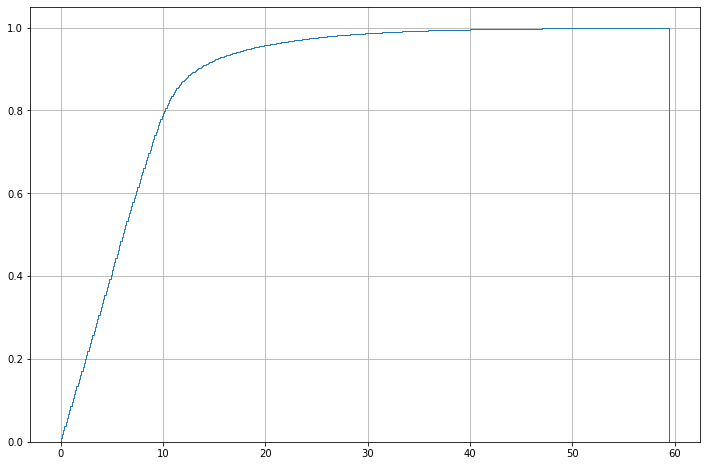

In [86]:
Error_FR_DBP = abs(test_labels_DBP - FR_Predictions_DBP);
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8));
ax.hist(Error_FR_DBP, 500, density=1, histtype='step', cumulative=True, label='Empirical');
plt.grid()

### 4.4 SVM

In [128]:
#    4) SVM: Support Vector Machine (Linear and Non-Linear)
# Linear SVM
from sklearn.svm import LinearSVR
SVM_reg_DBP = LinearSVR(epsilon=1.5) # was 1.5 with MAE=8.293
SVM_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
SVM_Predictions_DBP = SVM_reg_DBP.predict(test_copy_tr_DBP)
SVM_mse_DBP = mean_squared_error(test_labels_DBP, SVM_Predictions_DBP)
SVM_rmse_DBP = np.sqrt(SVM_mse_DBP)
print("SVM Regression RMSE: ",SVM_rmse_DBP)
# SVM with Poly Kernel

"""from sklearn.svm import SVR
SVM_poly_reg_DBP = SVR(kernel="poly", degree=2, C=100, epsilon=.1)
SVM_poly_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)
SVM_poly_Predictions_DBP = SVM_poly_reg_DBP.predict(test_copy_tr_DBP)
SVM_poly_mse_DBP = mean_squared_error(test_labels_DBP, SVM_poly_Predictions_DBP)
SVM_poly_rmse_DBP = np.sqrt(SVM_poly_mse_DBP)
print("SVM with kernel Regression RMSE: ",SVM_poly_rmse_DBP)

abs_error_DBP = [abs(test_labels_DBP.values[l] - SVM_Predictions_DBP[l]) for l in range(len(SVM_Predictions_DBP))]
mean_error_vec_DBP = [sum(abs_error_DBP)/len(abs_error_DBP)]*len(abs_error_DBP)
"""

SVM Regression RMSE:  10.693617639222603


C:\Users\ahmedk1\.conda\envs\fromBase\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


'from sklearn.svm import SVR\nSVM_poly_reg_DBP = SVR(kernel="poly", degree=2, C=100, epsilon=.1)\nSVM_poly_reg_DBP.fit(train_copy2_tr_DBP, train_labels_DBP)\nSVM_poly_Predictions_DBP = SVM_poly_reg_DBP.predict(test_copy_tr_DBP)\nSVM_poly_mse_DBP = mean_squared_error(test_labels_DBP, SVM_poly_Predictions_DBP)\nSVM_poly_rmse_DBP = np.sqrt(SVM_poly_mse_DBP)\nprint("SVM with kernel Regression RMSE: ",SVM_poly_rmse_DBP)\n\nabs_error_DBP = [abs(test_labels_DBP.values[l] - SVM_Predictions_DBP[l]) for l in range(len(SVM_Predictions_DBP))]\nmean_error_vec_DBP = [sum(abs_error_DBP)/len(abs_error_DBP)]*len(abs_error_DBP)\n'

In [119]:
np.mean(abs(test_labels_DBP - SVM_Predictions_DBP))

8.367996621448686

In [111]:
import m2cgen as m2c
print(m2c.export_to_c(SVM_reg_DBP))

double score(double * input) {
    return ((58.77603006726146) + ((input[0]) * (0.8671294121438181))) + ((input[1]) * (0.08468247585961933));
}



In [28]:
import joblib
# Saving DBP Estimation Models:

joblib.dump(lin_reg_DBP,"lin_reg_DBP0324.pkl")
joblib.dump(tree_reg_DBP,"tree_reg_DBP0324.pkl")
joblib.dump(forest_reg_DBP,"forest_reg_DBP0324.pkl")
joblib.dump(SVM_reg_DBP,"SVM_reg_DBP0324.pkl")
#joblib.dump(,"0324.pkl")

# to load it, just use: xyz = joblib.load("model_name_as_saved.pkl")

['SVM_reg_DBP0324.pkl']